# Complete HPC Fuzzing Pipeline with REAL Change-Aware Coverage

**🔥 NEW: This notebook uses actual line-by-line coverage measurement instead of proxy!**

Full pipeline from patch analysis to fuzzing test execution using SWE-bench containers.

## Pipeline Stages:

### STATIC ANALYSIS (Host)
1. Patch Loading
2. Repository Setup  
3. Static Analysis (Pylint, Flake8, Radon, Mypy, Bandit)

### DYNAMIC ANALYSIS (Container)
4. Build Instance-Specific Singularity Container
5. Install Dependencies (Copy C extensions from /testbed)
6. Run Existing Tests **WITH COVERAGE**
7. Patch Analysis
8. Generate Change-Aware Fuzzing Tests (Hypothesis)
9. Install Hypothesis in Container
10. Execute Fuzzing Tests **WITH COVERAGE**
11. **REAL Change-Aware Coverage Analysis** ⚡
12. Final Verdict

## Imports

In [1]:
import sys, subprocess, os
from pathlib import Path
import json, time, ast
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import importlib

PROJECT_ROOT = Path.cwd()
sys.path.append(str(PROJECT_ROOT))

# Dataset and patch handling
from swebench_integration import DatasetLoader, PatchLoader

# Dynamic container building system
from swebench_singularity import Config, SingularityBuilder, DockerImageResolver

# Analysis modules
from verifier.dynamic_analyzers.patch_analyzer import PatchAnalyzer
from verifier.dynamic_analyzers.test_generator import HypothesisTestGenerator
from verifier.dynamic_analyzers.coverage_analyzer import CoverageAnalyzer  # ← NEW!
from verifier.dynamic_analyzers.analyze_coverage_unified import analyze_coverage_unified
from verifier.dynamic_analyzers import test_patch_singularity

# Reload to get latest changes
importlib.reload(test_patch_singularity)

from verifier.dynamic_analyzers.test_patch_singularity import (
    install_package_in_singularity, 
    run_tests_in_singularity,
    install_hypothesis_in_singularity,
    install_pytest_cov_in_singularity  # ← NEW! For coverage collection
)

# Static analysis
import streamlit.modules.static_eval.static_modules.code_quality as code_quality
import streamlit.modules.static_eval.static_modules.syntax_structure as syntax_structure
from verifier.utils.diff_utils import parse_unified_diff, filter_paths_to_py

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
print("✓ Imports OK (with reload)")

/fs/nexus-scratch/ihbas/miniconda3/envs/verifier_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ Imports OK (with reload)


## Configuration Setup

In [2]:
# Set Apptainer/Singularity environment variables
os.environ["APPTAINER_DOCKER_USERNAME"] = "nacheitor12"
os.environ["APPTAINER_DOCKER_PASSWORD"] = "wN/^4Me%,!5zz_q"
os.environ["SINGULARITY_DOCKER_USERNAME"] = "nacheitor12"
os.environ["SINGULARITY_DOCKER_PASSWORD"] = "wN/^4Me%,!5zz_q"

print("✓ Docker credentials set\n")

# Initialize configuration
config = Config()
config.set("singularity.cache_dir", "/fs/nexus-scratch/ihbas/.cache/swebench_singularity")
config.set("singularity.tmp_dir", "/fs/nexus-scratch/ihbas/.tmp/singularity_build")
config.set("singularity.cache_internal_dir", "/fs/nexus-scratch/ihbas/.singularity/cache")
config.set("singularity.build_timeout", 1800)
config.set("docker.max_retries", 3)
config.set("docker.image_patterns", [
    "swebench/sweb.eval.x86_64.{repo}_1776_{repo}-{version}:latest",
])

builder = SingularityBuilder(config)
resolver = DockerImageResolver(config)

print("✓ Configuration initialized")
print(f"  Singularity: {builder.check_singularity_available()}")

2025-12-02 10:50:46,435 - swebench_singularity.singularity_builder - INFO - Singularity available: apptainer version 1.4.4-1.el8


✓ Docker credentials set

✓ Configuration initialized
  Singularity: True


---
# STATIC ANALYSIS
---

## Stage 1: Load Patch

In [3]:
REPO_FILTER = "scikit-learn/scikit-learn"

loader = DatasetLoader("princeton-nlp/SWE-bench_Verified", hf_mode=True, split="test")
sample = next(loader.iter_samples(limit=1, filter_repo=REPO_FILTER), None)

if sample:
    instance_id = sample.get('metadata', {}).get('instance_id', 'unknown')
    print(f"✓ {instance_id}")
    print(f"  Repo: {sample['repo']}")
    print(f"\nPatch preview:\n{sample['patch'][:400]}...")
else:
    raise Exception(f"No sample found for {REPO_FILTER}")

✓ scikit-learn__scikit-learn-10297
  Repo: scikit-learn/scikit-learn

Patch preview:
diff --git a/sklearn/linear_model/ridge.py b/sklearn/linear_model/ridge.py
--- a/sklearn/linear_model/ridge.py
+++ b/sklearn/linear_model/ridge.py
@@ -1212,18 +1212,18 @@ class RidgeCV(_BaseRidgeCV, RegressorMixin):
 
     store_cv_values : boolean, default=False
         Flag indicating if the cross-validation values corresponding to
-        each alpha should be stored in the `cv_values_` attrib...


## Stage 2: Setup Repository

In [4]:
patcher = PatchLoader(sample=sample, repos_root="./repos_temp")
repo_path = patcher.clone_repository()
patch_result = patcher.apply_patch()

print(f"✓ Repo: {repo_path}")
print(f"✓ Patch: {'Applied' if patch_result['applied'] else 'FAILED'}")

[+] Cloning scikit-learn/scikit-learn into /fs/nexus-scratch/ihbas/verifier_harness/repos_temp/scikit-learn__scikit-learn ...
✓ Repo: /fs/nexus-scratch/ihbas/verifier_harness/repos_temp/scikit-learn__scikit-learn
✓ Patch: Applied


## Stage 2b: Apply Test Patch

In [5]:
test_patch = sample.get('metadata', {}).get('test_patch', '')

if test_patch and test_patch.strip():
    print("📝 Applying test_patch...")
    try:
        test_patch_result = patcher.apply_additional_patch(test_patch)
        print(f"✓ Test patch applied: {test_patch_result.get('log', 'success')}")
    except Exception as e:
        print(f"⚠️ Test patch application failed: {e}")
else:
    print("ℹ️  No test_patch in metadata")

📝 Applying test_patch...
✓ Test patch applied: Additional patch applied successfully.


## Stage 3: Static Analysis

In [6]:
static_config = {
    'checks': {'pylint': True, 'flake8': True, 'radon': True, 'mypy': True, 'bandit': True},
    'weights': {'pylint': 0.5, 'flake8': 0.15, 'radon': 0.25, 'mypy': 0.05, 'bandit': 0.05}
}

print("🔍 Static analysis...")
cq_results = code_quality.analyze(str(repo_path), sample['patch'], static_config)
ss_results = syntax_structure.run_syntax_structure_analysis(str(repo_path), sample['patch'])

sqi_data = cq_results.get('sqi', {})
print(f"✓ SQI: {sqi_data.get('SQI', 0)}/100 ({sqi_data.get('classification', 'Unknown')})")

🔍 Static analysis...
✓ SQI: 62.14/100 (Fair)


---
# DYNAMIC ANALYSIS (Container)
---

## Stage 4: Build Container

In [7]:
print(f"🐳 Building container for {instance_id}...\n")

docker_image = resolver.find_available_image(instance_id, check_existence=False)
if docker_image:
    print(f"  Docker image: {docker_image.full_name}\n")

build_result = builder.build_instance(
    instance_id=instance_id,
    force_rebuild=False,
    check_docker_exists=False
)

if build_result.success:
    CONTAINER_IMAGE_PATH = build_result.sif_path
    cache_status = "(from cache)" if build_result.from_cache else "(newly built)"
    print(f"✓ Container ready {cache_status}")
    print(f"  Path: {CONTAINER_IMAGE_PATH}")
else:
    raise Exception(f"Container build failed: {build_result.error_message}")

2025-12-02 10:51:46,223 - swebench_singularity.singularity_builder - INFO - Using cached image for scikit-learn__scikit-learn-10297: /fs/nexus-scratch/ihbas/.cache/swebench_singularity/scikit-learn/scikit-learn__scikit-learn-10297.sif


🐳 Building container for scikit-learn__scikit-learn-10297...

  Docker image: docker.io/swebench/sweb.eval.x86_64.scikit-learn_1776_scikit-learn-10297:latest

✓ Container ready (from cache)
  Path: /fs/nexus-scratch/ihbas/.cache/swebench_singularity/scikit-learn/scikit-learn__scikit-learn-10297.sif


## Stage 5: Install Dependencies

In [8]:
print("📦 Installing dependencies...\n")

install_result = install_package_in_singularity(
    repo_path=Path(repo_path),
    image_path=str(CONTAINER_IMAGE_PATH)
)

if install_result.get("installed"):
    print("✓ Dependencies installed")
else:
    print("ℹ️  Using PYTHONPATH mode")



📦 Installing dependencies...

📦 Preparing package for testing in: /fs/nexus-scratch/ihbas/verifier_harness/repos_temp/scikit-learn__scikit-learn
   Setup files found: setup.py=True, pyproject.toml=False, setup.cfg=True
   Copying pre-built C extensions from container...
✅ Successfully copied 40 pre-built C extension files
✓ Dependencies installed


## Stage 5b: Install pytest-cov for Coverage Collection

In [9]:
print("📦 Installing pytest-cov for coverage collection...\n")

pytest_cov_result = install_pytest_cov_in_singularity(
    repo_path=Path(repo_path),
    image_path=str(CONTAINER_IMAGE_PATH)
)

if pytest_cov_result['installed']:
    print("✓ pytest-cov ready for coverage collection")
    print(f"  Installed to: {pytest_cov_result['packages_dir']}\n")
else:
    print("⚠️  pytest-cov installation failed")
    print(f"  Error: {pytest_cov_result.get('stderr', 'Unknown')[:200]}\n")

📦 Installing pytest-cov for coverage collection...

📦 Installing pytest-cov to /fs/nexus-scratch/ihbas/verifier_harness/repos_temp/scikit-learn__scikit-learn/.pip_packages...
✅ pytest-cov installed successfully to .pip_packages/
✓ pytest-cov ready for coverage collection
  Installed to: /fs/nexus-scratch/ihbas/verifier_harness/repos_temp/scikit-learn__scikit-learn/.pip_packages



## Stage 7: Analyze Patch (moved before tests to get module info)

In [10]:
print("🔍 Analyzing patch for test generation...\n")

patch_analyzer = PatchAnalyzer()
parsed_diff = parse_unified_diff(sample['patch'])
modified_files = filter_paths_to_py(list(parsed_diff.keys()))

if modified_files:
    first_file_path = modified_files[0]
    first_file = Path(repo_path) / first_file_path
    patched_code = first_file.read_text(encoding='utf-8')
    
    patch_analysis = patch_analyzer.parse_patch(sample['patch'], patched_code, file_path=first_file_path)
    
    print(f"✓ Files changed: {len(modified_files)}")
    print(f"  Module: {patch_analysis.module_path}")
    print(f"  Functions: {patch_analysis.changed_functions}")
    if patch_analysis.class_context:
        print(f"  Classes: {list(patch_analysis.class_context.values())}")
    print(f"  Changed lines: {len(patch_analysis.all_changed_lines)}")
    print(f"  Line numbers: {sorted(patch_analysis.all_changed_lines)}")
else:
    patch_analysis = None
    patched_code = None
    print("⚠️ No Python files modified")

🔍 Analyzing patch for test generation...

✓ Files changed: 1
  Module: sklearn.linear_model.ridge
  Functions: ['__init__']
  Classes: ['RidgeClassifierCV']
  Changed lines: 20
  Line numbers: [1215, 1216, 1223, 1224, 1225, 1226, 1304, 1305, 1306, 1307, 1308, 1309, 1312, 1313, 1314, 1315, 1316, 1341, 1342, 1345]


## Stage 6: Run Existing Tests WITH COVERAGE 🔥

In [11]:
print("🧪 Running existing tests WITH COVERAGE (BASELINE)...\n")

fail_to_pass = sample.get('metadata', {}).get('FAIL_TO_PASS', '[]')
pass_to_pass = sample.get('metadata', {}).get('PASS_TO_PASS', '[]')

try:
    f2p = ast.literal_eval(fail_to_pass) if isinstance(fail_to_pass, str) else fail_to_pass
    p2p = ast.literal_eval(pass_to_pass) if isinstance(pass_to_pass, str) else pass_to_pass
except:
    f2p, p2p = [], []

all_tests = f2p + p2p

# Determine coverage source from patch analysis
if patch_analysis and patch_analysis.module_path:
    # Extract top-level module (e.g., 'sklearn' from 'sklearn.linear_model.ridge')
    coverage_source = patch_analysis.module_path.split('.')[0]
    print(f"📊 Coverage will be collected for module: {coverage_source}\n")
else:
    coverage_source = None

test_result = run_tests_in_singularity(
    repo_path=Path(repo_path),
    tests=all_tests,
    image_path=str(CONTAINER_IMAGE_PATH),
    collect_coverage=True,  # 🔥 ENABLE COVERAGE!
    coverage_source=coverage_source,
)

print(f"\nExit code: {test_result['returncode']}")
print(f"{'✓' if test_result['returncode'] == 0 else '⚠️'} Tests {'passed' if test_result['returncode'] == 0 else 'had issues'}")

# ANALYZE BASELINE COVERAGE (Existing Tests Only) - WITH BRANCH COVERAGE
if 'coverage_file' in test_result and test_result['coverage_file']:
    baseline_cov_file = Path(test_result['coverage_file'])
    
    if baseline_cov_file.exists():
        print(f"\n✓ Existing tests coverage collected: {baseline_cov_file.name}")
        
        # Load coverage data
        baseline_coverage_data = json.loads(baseline_cov_file.read_text())
        analyzer = CoverageAnalyzer()
        
        # Analyze BOTH line and branch coverage together
        baseline_analysis = analyze_coverage_unified(
            coverage_data=baseline_coverage_data,
            patch_analysis=patch_analysis,
            analyzer=analyzer,
            label="BASELINE (Existing Tests Only)"
        )
        
        if baseline_analysis:
            baseline_coverage = baseline_analysis['line_coverage']
            baseline_covered_lines = baseline_analysis['covered_lines']
            baseline_branch_coverage = baseline_analysis['branch_coverage']
        else:
            baseline_coverage = 0.0
            baseline_covered_lines = set()
            baseline_branch_coverage = 0.0
    else:
        baseline_coverage = 0.0
        baseline_covered_lines = set()
        baseline_branch_coverage = 0.0
        print("\n⚠️ No baseline coverage data")
else:
    baseline_coverage = 0.0
    baseline_covered_lines = set()
    baseline_branch_coverage = 0.0
    print("\n⚠️ No baseline coverage data")

🧪 Running existing tests WITH COVERAGE (BASELINE)...

📊 Coverage will be collected for module: sklearn

ℹ️  Using existing C extensions (41 files)
📊 Coverage collection enabled for: sklearn (with branch coverage)
🧪 Running tests in Singularity:
  singularity exec --bind /fs/nexus-scratch/ihbas/verifier_harness/repos_temp/scikit-learn__scikit-learn:/workspace --pwd /workspace --env PYTHONPATH=/workspace/.pip_packages:/workspace /fs/nexus-scratch/ihbas/.cache/swebench_singularity/scikit-learn/scikit-learn__scikit-learn-10297.sif /opt/miniconda3/envs/testbed/bin/python -m pytest -q --cov=sklearn --cov-branch --cov-report=term-missing:skip-covered sklearn/linear_model/tests/test_ridge.py::test_ridge_classifier_cv_store_cv_values sklearn/linear_model/tests/test_ridge.py::test_ridge sklearn/linear_model/tests/test_ridge.py::test_primal_dual_relationship sklearn/linear_model/tests/test_ridge.py::test_ridge_singular sklearn/linear_model/tests/test_ridge.py::test_ridge_regression_sample_weights

## Stage 8: Generate Change-Aware Fuzzing Tests

In [12]:
if patch_analysis and patch_analysis.changed_functions:
    print("🧬 Generating change-aware fuzzing tests...\n")
    
    # 🔥 FIX: Pass repo_path to enable pattern learning from existing tests
    test_generator = HypothesisTestGenerator(repo_path=Path(repo_path))
    test_code = test_generator.generate_tests(patch_analysis, patched_code)
    test_count = test_code.count('def test_')
    
    # Save to file
    test_file = Path(repo_path) / "test_fuzzing_generated.py"
    test_file.write_text(test_code, encoding='utf-8')
    
    print(f"✓ Generated {test_count} hypothesis-based tests")
    print(f"  Saved to: {test_file.name}")
    print(f"\nPreview:\n{test_code[:500]}...")
else:
    test_code = None
    test_count = 0
    print("⚠️ No tests generated (no functions changed)")

🧬 Generating change-aware fuzzing tests...

✓ Generated 1 hypothesis-based tests
  Saved to: test_fuzzing_generated.py

Preview:
# Auto-generated change-aware fuzzing tests for patch validation
import pytest
from hypothesis import given, strategies as st, settings
from hypothesis import assume
import sys
from pathlib import Path

# Import from patched module: sklearn.linear_model.ridge
from sklearn.linear_model.ridge import RidgeClassifierCV

# Hypothesis strategies learned from existing tests
@given(alphas=st.sampled_from([[0.01, 0.1, 1], [0.01, 0.1, 1, 10]]), class_weight=st.sampled_from([{1: 0.001}]), store_cv_values=s...


## Stage 9: Execute Fuzzing Tests WITH COVERAGE 🔥

In [13]:
if test_code and test_count > 0:
    print("📦 Preparing container for fuzzing tests...\n")
    
    # Install hypothesis
    hypothesis_install = install_hypothesis_in_singularity(
        repo_path=Path(repo_path),
        image_path=str(CONTAINER_IMAGE_PATH)
    )
    
    if hypothesis_install['installed']:
        print("✓ Container ready for fuzzing tests\n")
    else:
        print("ℹ️  Hypothesis may already be available\n")
    
    # IMPORTANT: Rename baseline .coverage.json to preserve it
    # The fuzzing test run will create a new .coverage file
    baseline_cov_json = Path(repo_path) / ".coverage.json"
    baseline_cov_db = Path(repo_path) / ".coverage"
    
    if baseline_cov_json.exists():
        baseline_cov_json.rename(Path(repo_path) / ".coverage.baseline.json")
        print("✓ Preserved baseline coverage data\n")
    
    if baseline_cov_db.exists():
        baseline_cov_db.unlink()  # Remove old .coverage db so fuzzing creates fresh one
    
    print("🐳 Executing fuzzing tests WITH COVERAGE...\n")
    
    fuzzing_result = run_tests_in_singularity(
        repo_path=Path(repo_path),
        tests=["test_fuzzing_generated.py"],
        image_path=str(CONTAINER_IMAGE_PATH),
        extra_env={"HYPOTHESIS_MAX_EXAMPLES": "50"},
        collect_coverage=True,  # 🔥 ENABLE COVERAGE!
        coverage_source=coverage_source,
    )
    
    print(f"\nExit code: {fuzzing_result['returncode']}")
    
    # Parse output
    output = fuzzing_result.get('stdout', '') + fuzzing_result.get('stderr', '')
    
    if 'passed' in output.lower():
        import re
        match = re.search(r'(\d+) passed', output)
        passed = int(match.group(1)) if match else 0
        
        match_failed = re.search(r'(\d+) failed', output)
        failed = int(match_failed.group(1)) if match_failed else 0
        
        print(f"\n✓ Fuzzing tests: {passed} passed")
        if failed > 0:
            print(f"  ⚠️ {failed} failed")
        
        fuzzing_success = (fuzzing_result['returncode'] == 0)
    else:
        print(f"\n⚠️ Tests had collection/execution issues")
        fuzzing_success = False
    
    # ANALYZE FUZZING COVERAGE - WITH BRANCH COVERAGE
    if 'coverage_file' in fuzzing_result and fuzzing_result['coverage_file']:
        fuzzing_cov_file = Path(fuzzing_result['coverage_file'])
        
        if fuzzing_cov_file.exists():
            print(f"\n✓ Fuzzing coverage collected: {fuzzing_cov_file.name}")
            
            # Load and analyze fuzzing coverage
            fuzzing_coverage_data = json.loads(fuzzing_cov_file.read_text())
            
            fuzzing_analysis = analyze_coverage_unified(
                coverage_data=fuzzing_coverage_data,
                patch_analysis=patch_analysis,
                analyzer=CoverageAnalyzer(),
                label="FUZZING-ONLY"
            )
            
            if fuzzing_analysis:
                fuzzing_only_covered = fuzzing_analysis['covered_lines']
                fuzzing_branch_coverage = fuzzing_analysis['branch_coverage']
                
                # COMBINE: baseline + fuzzing
                combined_covered_lines = baseline_covered_lines | fuzzing_only_covered
                all_changed = set(patch_analysis.all_changed_lines) if patch_analysis else set()
                combined_uncovered_lines = sorted(list(all_changed - combined_covered_lines))
                combined_coverage = len(combined_covered_lines) / len(all_changed) if all_changed else 0.0
                
                # Branch coverage: take the max of baseline or fuzzing
                combined_branch_coverage = max(baseline_branch_coverage, fuzzing_branch_coverage)
                
                print(f"\n📊 COMBINED COVERAGE (Baseline + Fuzzing):")
                print(f"   Line coverage: {combined_coverage*100:.1f}%")
                print(f"   Covered lines: {sorted(list(combined_covered_lines))}")
                print(f"   Uncovered lines: {combined_uncovered_lines}")
                if fuzzing_branch_coverage > 0 or baseline_branch_coverage > 0:
                    print(f"   Branch coverage: {combined_branch_coverage*100:.1f}%")
                else:
                    print(f"   ℹ️  Branch coverage: N/A (no conditional branches in changed code)")
            else:
                combined_coverage = baseline_coverage
                combined_covered_lines = baseline_covered_lines
                combined_uncovered_lines = sorted(list(set(patch_analysis.all_changed_lines) - baseline_covered_lines)) if patch_analysis else []
                combined_branch_coverage = baseline_branch_coverage
        else:
            print(f"\n⚠️ Fuzzing coverage file not found")
            combined_coverage = baseline_coverage
            combined_covered_lines = baseline_covered_lines
            combined_uncovered_lines = sorted(list(set(patch_analysis.all_changed_lines) - baseline_covered_lines)) if patch_analysis else []
            combined_branch_coverage = baseline_branch_coverage
    else:
        print("\n⚠️ No fuzzing coverage data")
        combined_coverage = baseline_coverage
        combined_covered_lines = baseline_covered_lines
        combined_uncovered_lines = sorted(list(set(patch_analysis.all_changed_lines) - baseline_covered_lines)) if patch_analysis else []
        combined_branch_coverage = baseline_branch_coverage
    
    print(f"\nOutput (last 800 chars):\n{output[-800:]}")
else:
    fuzzing_success = True
    combined_coverage = baseline_coverage
    combined_covered_lines = baseline_covered_lines
    combined_uncovered_lines = sorted(list(set(patch_analysis.all_changed_lines) - baseline_covered_lines)) if patch_analysis else []
    combined_branch_coverage = baseline_branch_coverage if 'baseline_branch_coverage' in locals() else 0.0
    print("ℹ️  No fuzzing tests to execute")

📦 Preparing container for fuzzing tests...

📦 Installing hypothesis to /fs/nexus-scratch/ihbas/verifier_harness/repos_temp/scikit-learn__scikit-learn/.pip_packages...
✅ Hypothesis installed successfully to .pip_packages/
✓ Container ready for fuzzing tests

✓ Preserved baseline coverage data

🐳 Executing fuzzing tests WITH COVERAGE...

ℹ️  Using existing C extensions (41 files)
📊 Coverage collection enabled for: sklearn (with branch coverage)
🧪 Running tests in Singularity:
  singularity exec --bind /fs/nexus-scratch/ihbas/verifier_harness/repos_temp/scikit-learn__scikit-learn:/workspace --pwd /workspace --env PYTHONPATH=/workspace/.pip_packages:/workspace --env HYPOTHESIS_MAX_EXAMPLES=50 /fs/nexus-scratch/ihbas/.cache/swebench_singularity/scikit-learn/scikit-learn__scikit-learn-10297.sif /opt/miniconda3/envs/testbed/bin/python -m pytest -q --cov=sklearn --cov-branch --cov-report=term-missing:skip-covered test_fuzzing_generated.py

✓ Coverage data saved to: .coverage.json

Exit code: 0

## Stage 10: REAL Change-Aware Coverage Analysis 🚀🔥

In [14]:
print("="*80)
print("BASELINE vs COMBINED COVERAGE COMPARISON")
print("="*80)
print()

if patch_analysis and 'baseline_coverage' in locals():
    # Calculate improvement metrics
    coverage_improvement = combined_coverage - baseline_coverage
    fuzzing_added_lines = combined_covered_lines - baseline_covered_lines
    
    total_changed = len(patch_analysis.all_changed_lines)
    baseline_covered_count = len(baseline_covered_lines)
    combined_covered_count = len(combined_covered_lines)
    fuzzing_added_count = len(fuzzing_added_lines)
    
    print(f"📊 BASELINE COVERAGE (Existing Tests Only):")
    print(f"   Line coverage: {baseline_coverage*100:.1f}%")
    print(f"   Lines covered: {baseline_covered_count}/{total_changed}")
    print(f"   Covered line numbers: {sorted(list(baseline_covered_lines))}")
    
    print(f"\n📊 COMBINED COVERAGE (Existing + Fuzzing Tests):")
    print(f"   Line coverage: {combined_coverage*100:.1f}%")
    print(f"   Lines covered: {combined_covered_count}/{total_changed}")
    print(f"   Covered line numbers: {sorted(list(combined_covered_lines))}")
    
    print(f"\n🎯 FUZZING CONTRIBUTION:")
    if fuzzing_added_count > 0:
        print(f"   ✅ Line coverage improvement: +{coverage_improvement*100:.1f}%")
        print(f"   ✅ New lines covered by fuzzing: {fuzzing_added_count}")
        print(f"   ✅ Line numbers: {sorted(list(fuzzing_added_lines))}")
    else:
        print(f"   ℹ️  No additional line coverage from fuzzing tests")
        print(f"   💡 Fuzzing tests validated existing coverage but didn't add new line coverage")
    
    print(f"\n⚠️  REMAINING UNCOVERED LINES:")
    if combined_uncovered_lines:
        print(f"   Count: {len(combined_uncovered_lines)}/{total_changed}")
        print(f"   Line numbers: {combined_uncovered_lines}")
        print(f"   ❌ These lines remain UNTESTED even with fuzzing!")
    else:
        print(f"   ✅ EXCELLENT: All changed lines are now covered!")
    
    # Store final metrics for verdict stage
    actual_coverage = combined_coverage
    covered_lines = sorted(list(combined_covered_lines))
    uncovered_lines = combined_uncovered_lines
    total_covered = combined_covered_count
    
    print("\n" + "="*80)
    print(f"📈 FINAL SUMMARY:")
    print(f"  Total changed lines: {total_changed}")
    print(f"  Baseline line coverage: {baseline_coverage*100:.1f}% ({baseline_covered_count} lines)")
    print(f"  Combined line coverage: {combined_coverage*100:.1f}% ({combined_covered_count} lines)")
    print(f"  Line coverage improvement: +{coverage_improvement*100:.1f}% (+{fuzzing_added_count} lines)")
    
    # Add branch coverage if applicable
    if 'baseline_branch_coverage' in locals() and 'combined_branch_coverage' in locals():
        branch_improvement = combined_branch_coverage - baseline_branch_coverage
        if baseline_branch_coverage > 0 or combined_branch_coverage > 0:
            print(f"\n  Baseline branch coverage: {baseline_branch_coverage*100:.1f}%")
            print(f"  Combined branch coverage: {combined_branch_coverage*100:.1f}%")
            print(f"  Branch coverage improvement: +{branch_improvement*100:.1f}%")
        else:
            print(f"\n  ℹ️  Branch coverage: N/A (no conditional branches in changed code)")
    
    print(f"\n  Still uncovered: {len(combined_uncovered_lines)} lines")
    print("="*80)
    
else:
    print("⚠️ No baseline coverage analysis available")
    print("   Cannot compare baseline vs combined coverage\n")
    
    # Fallback: just use any available coverage
    if 'combined_coverage' in locals():
        actual_coverage = combined_coverage
        covered_lines = sorted(list(combined_covered_lines))
        uncovered_lines = combined_uncovered_lines
        total_covered = len(combined_covered_lines)
        total_changed = len(patch_analysis.all_changed_lines) if patch_analysis else 0
    else:
        # Ultimate fallback to proxy
        existing_passed = (test_result['returncode'] == 0)
        actual_coverage = 0.5 if existing_passed else 0.0
        covered_lines = []
        uncovered_lines = patch_analysis.all_changed_lines if patch_analysis else []
        total_changed = len(uncovered_lines)
        total_covered = 0
        
        print(f"  Coverage proxy: {actual_coverage*100:.1f}%")
        print(f"  (Based on test pass/fail, not actual line coverage)")

BASELINE vs COMBINED COVERAGE COMPARISON

📊 BASELINE COVERAGE (Existing Tests Only):
   Line coverage: 20.0%
   Lines covered: 4/20
   Covered line numbers: [1313, 1314, 1315, 1345]

📊 COMBINED COVERAGE (Existing + Fuzzing Tests):
   Line coverage: 20.0%
   Lines covered: 4/20
   Covered line numbers: [1313, 1314, 1315, 1345]

🎯 FUZZING CONTRIBUTION:
   ℹ️  No additional line coverage from fuzzing tests
   💡 Fuzzing tests validated existing coverage but didn't add new line coverage

⚠️  REMAINING UNCOVERED LINES:
   Count: 16/20
   Line numbers: [1215, 1216, 1223, 1224, 1225, 1226, 1304, 1305, 1306, 1307, 1308, 1309, 1312, 1316, 1341, 1342]
   ❌ These lines remain UNTESTED even with fuzzing!

📈 FINAL SUMMARY:
  Total changed lines: 20
  Baseline line coverage: 20.0% (4 lines)
  Combined line coverage: 20.0% (4 lines)
  Line coverage improvement: +0.0% (+0 lines)

  Baseline branch coverage: 100.0%
  Combined branch coverage: 100.0%
  Branch coverage improvement: +0.0%

  Still uncovere

In [15]:
# Analyze branch coverage from baseline and fuzzing tests
if patch_analysis and 'baseline_coverage_data' in locals() and baseline_cov_file.exists():
    print("\n" + "="*80)
    print("BRANCH COVERAGE ANALYSIS")
    print("="*80)
    
    # Get baseline branch coverage
    baseline_branch_result = analyzer.calculate_branch_coverage(
        coverage_data=baseline_coverage_data,
        changed_lines=patch_analysis.all_changed_lines if patch_analysis else []
    )
    
    baseline_total_branches = baseline_branch_result.get('total_branches', 0)
    baseline_covered_branches = baseline_branch_result.get('covered_branches', 0)
    baseline_branch_coverage = baseline_branch_result.get('coverage', 0.0)
    baseline_missing_branches = baseline_branch_result.get('missing_branches', [])
    
    print(f"\n📊 BASELINE BRANCH COVERAGE (Existing Tests Only):")
    print(f"   Total branches: {baseline_total_branches}")
    print(f"   Covered branches: {baseline_covered_branches}")
    print(f"   Branch coverage: {baseline_branch_coverage*100:.1f}%")
    
    if baseline_missing_branches:
        print(f"   Missing branches: {baseline_missing_branches[:5]}")
        if len(baseline_missing_branches) > 5:
            print(f"   ... and {len(baseline_missing_branches) - 5} more")
    
    # Get fuzzing branch coverage if available
    if 'fuzzing_coverage_data' in locals() and fuzzing_cov_file.exists():
        fuzzing_branch_result = analyzer.calculate_branch_coverage(
            coverage_data=fuzzing_coverage_data,
            changed_lines=patch_analysis.all_changed_lines if patch_analysis else []
        )
        
        fuzzing_missing_branches = set(fuzzing_branch_result.get('missing_branches', []))
        
        # Combine: branches missing in both baseline and fuzzing
        baseline_missing_set = set(baseline_missing_branches)
        combined_missing_branches = baseline_missing_set & fuzzing_missing_branches
        
        # Calculate combined branch coverage
        if baseline_total_branches > 0:
            combined_branch_coverage = 1.0 - (len(combined_missing_branches) / baseline_total_branches)
        else:
            combined_branch_coverage = 0.0
        
        combined_covered_branches = baseline_total_branches - len(combined_missing_branches)
        
        print(f"\n📊 COMBINED BRANCH COVERAGE (Existing + Fuzzing):")
        print(f"   Total branches: {baseline_total_branches}")
        print(f"   Covered branches: {combined_covered_branches}")
        print(f"   Branch coverage: {combined_branch_coverage*100:.1f}%")
        
        # Calculate fuzzing contribution
        branch_improvement = combined_branch_coverage - baseline_branch_coverage
        branches_added = combined_covered_branches - baseline_covered_branches
        
        print(f"\n🎯 FUZZING CONTRIBUTION TO BRANCHES:")
        if branches_added > 0:
            print(f"   ✅ Improvement: +{branch_improvement*100:.1f}%")
            print(f"   ✅ New branches covered: {branches_added}")
        else:
            print(f"   ℹ️  No additional branches covered by fuzzing")
        
        if combined_missing_branches:
            print(f"\n⚠️  REMAINING UNTESTED BRANCHES:")
            print(f"   Count: {len(combined_missing_branches)}/{baseline_total_branches}")
            missing_list = list(combined_missing_branches)[:5]
            for line, branch_id in missing_list:
                branch_type = "True" if branch_id == 0 else "False"
                print(f"   Line {line}: {branch_type} branch never executed")
            if len(combined_missing_branches) > 5:
                print(f"   ... and {len(combined_missing_branches) - 5} more untested branches")
        else:
            print(f"\n✅ EXCELLENT: All branches in changed code are now covered!")
        
        # Store for final verdict
        final_branch_coverage = combined_branch_coverage
    else:
        # Only baseline available
        final_branch_coverage = baseline_branch_coverage
        print(f"\n   (Fuzzing branch coverage data not available)")
    
    print("\n" + "="*80)
else:
    print("\nℹ️  Branch coverage analysis skipped (no coverage data available)")
    final_branch_coverage = 0.0



BRANCH COVERAGE ANALYSIS

📊 BASELINE BRANCH COVERAGE (Existing Tests Only):
   Total branches: 0
   Covered branches: 0
   Branch coverage: 0.0%

📊 COMBINED BRANCH COVERAGE (Existing + Fuzzing):
   Total branches: 0
   Covered branches: 0
   Branch coverage: 0.0%

🎯 FUZZING CONTRIBUTION TO BRANCHES:
   ℹ️  No additional branches covered by fuzzing

✅ EXCELLENT: All branches in changed code are now covered!



In [16]:
print("\n" + "="*80)
print("FINAL VERDICT")
print("="*80)

# Collect metrics
sqi_score = sqi_data.get('SQI', 0) / 100.0
existing_tests_pass = (test_result['returncode'] == 0)

# Use branch coverage if available, otherwise 0
branch_coverage_score = final_branch_coverage if 'final_branch_coverage' in locals() else 0.0

# Calculate overall score with REAL coverage + branch coverage 🔥
overall_score = (
    sqi_score * 30 +  # Static analysis: 30%
    (100 if existing_tests_pass else 0) * 0.40 +  # Existing tests: 40%
    (100 if fuzzing_success else 0) * 0.15 +  # Fuzzing tests: 15%
    actual_coverage * 100 * 0.10 +  # Line coverage: 10%
    branch_coverage_score * 100 * 0.05  # Branch coverage: 5% 🔥 NEW!
)

# Determine verdict with coverage consideration
if actual_coverage < 0.5:
    coverage_warning = " (⚠️ Low coverage of changed code)"
elif actual_coverage < 0.8:
    coverage_warning = " (⚠️ Moderate coverage)"
else:
    coverage_warning = " (✓ High coverage)"

if overall_score >= 80:
    verdict = "✅ EXCELLENT" + coverage_warning
    color = "green"
elif overall_score >= 60:
    verdict = "✓ GOOD" + coverage_warning
    color = "blue"
elif overall_score >= 40:
    verdict = "⚠️ FAIR" + coverage_warning
    color = "orange"
else:
    verdict = "❌ POOR" + coverage_warning
    color = "red"

# Print summary
print(f"\nInstance: {instance_id}")
print(f"Overall Score: {overall_score:.1f}/100")
print(f"Verdict: {verdict}\n")

print("Component Scores:")
print(f"  Static Analysis (SQI): {sqi_score*100:.1f}/100 ({sqi_data.get('classification', 'Unknown')})")
print(f"  Existing Tests: {'PASS' if existing_tests_pass else 'FAIL'} ({len(all_tests)} tests)")
print(f"  Fuzzing Tests: {'PASS' if fuzzing_success else 'FAIL'} ({test_count} generated)")

# Show coverage breakdown
if 'baseline_coverage' in locals() and 'combined_coverage' in locals():
    print(f"\nCoverage Analysis (Change-Aware):")
    print(f"  Baseline (existing tests): {baseline_coverage*100:.1f}% ({len(baseline_covered_lines)}/{total_changed} lines)")
    print(f"  Combined (existing + fuzzing): {combined_coverage*100:.1f}% ({total_covered}/{total_changed} lines)")
    
    if 'fuzzing_added_lines' in locals():
        improvement = combined_coverage - baseline_coverage
        print(f"  Fuzzing contribution: +{improvement*100:.1f}% (+{len(fuzzing_added_lines)} lines) 🔥")
    
    # Add branch coverage info if available
    if 'final_branch_coverage' in locals():
        print(f"\n  Branch Coverage: {final_branch_coverage*100:.1f}% 🌿")
else:
    print(f"  Change-Aware Coverage: {actual_coverage*100:.1f}% ({total_covered}/{total_changed} lines) 🔥")

if uncovered_lines and len(uncovered_lines) > 0:
    print(f"\n⚠️  WARNING: {len(uncovered_lines)} changed lines remain UNTESTED")
    print(f"   Line numbers: {uncovered_lines[:20]}")
    if len(uncovered_lines) > 20:
        print(f"   ... and {len(uncovered_lines) - 20} more")

# Save results with baseline vs combined metrics + branch coverage
results = {
    'instance_id': instance_id,
    'overall_score': overall_score,
    'verdict': verdict,
    'sqi_score': sqi_score * 100,
    'existing_tests_passed': existing_tests_pass,
    'fuzzing_tests_passed': fuzzing_success,
    'fuzzing_tests_count': test_count,
    'baseline_coverage': baseline_coverage * 100 if 'baseline_coverage' in locals() else None,
    'combined_coverage': actual_coverage * 100,  # 🔥 REAL COMBINED COVERAGE
    'branch_coverage': branch_coverage_score * 100,  # 🔥 NEW: Branch coverage
    'fuzzing_contribution': (combined_coverage - baseline_coverage) * 100 if 'baseline_coverage' in locals() else None,
    'baseline_covered_lines': len(baseline_covered_lines) if 'baseline_covered_lines' in locals() else 0,
    'combined_covered_lines': total_covered,
    'fuzzing_added_lines': len(fuzzing_added_lines) if 'fuzzing_added_lines' in locals() else 0,
    'total_changed_lines': total_changed,
    'uncovered_lines': uncovered_lines,
    'coverage_method': 'real_combined_with_branches',  # 🔥 UPDATED
}

with open('fuzzing_pipeline_results_REAL_COVERAGE.json', 'w') as f:
    json.dump(results, f, indent=2)

print(f"\n💾 Results saved to fuzzing_pipeline_results_REAL_COVERAGE.json")
print("="*80)



FINAL VERDICT

Instance: scikit-learn__scikit-learn-10297
Overall Score: 75.6/100
Verdict: ✓ GOOD (⚠️ Low coverage of changed code)

Component Scores:
  Static Analysis (SQI): 62.1/100 (Fair)
  Existing Tests: PASS (29 tests)
  Fuzzing Tests: PASS (1 generated)

Coverage Analysis (Change-Aware):
  Baseline (existing tests): 20.0% (4/20 lines)
  Combined (existing + fuzzing): 20.0% (4/20 lines)
  Fuzzing contribution: +0.0% (+0 lines) 🔥

  Branch Coverage: 0.0% 🌿

⚠️  WARNING: 16 changed lines remain UNTESTED
   Line numbers: [1215, 1216, 1223, 1224, 1225, 1226, 1304, 1305, 1306, 1307, 1308, 1309, 1312, 1316, 1341, 1342]

💾 Results saved to fuzzing_pipeline_results_REAL_COVERAGE.json


In [17]:
print("\n" + "="*80)
print("FINAL VERDICT")
print("="*80)

# Collect metrics
sqi_score = sqi_data.get('SQI', 0) / 100.0
existing_tests_pass = (test_result['returncode'] == 0)

# Use combined branch coverage if available, otherwise 0
branch_coverage_score = combined_branch_coverage if 'combined_branch_coverage' in locals() else 0.0

# Calculate overall score with REAL coverage + branch coverage 🔥
overall_score = (
    sqi_score * 30 +  # Static analysis: 30%
    (100 if existing_tests_pass else 0) * 0.40 +  # Existing tests: 40%
    (100 if fuzzing_success else 0) * 0.15 +  # Fuzzing tests: 15%
    actual_coverage * 100 * 0.10 +  # Line coverage: 10%
    branch_coverage_score * 100 * 0.05  # Branch coverage: 5% 🔥
)

# Determine verdict with coverage consideration
if actual_coverage < 0.5:
    coverage_warning = " (⚠️ Low coverage of changed code)"
elif actual_coverage < 0.8:
    coverage_warning = " (⚠️ Moderate coverage)"
else:
    coverage_warning = " (✓ High coverage)"

if overall_score >= 80:
    verdict = "✅ EXCELLENT" + coverage_warning
    color = "green"
elif overall_score >= 60:
    verdict = "✓ GOOD" + coverage_warning
    color = "blue"
elif overall_score >= 40:
    verdict = "⚠️ FAIR" + coverage_warning
    color = "orange"
else:
    verdict = "❌ POOR" + coverage_warning
    color = "red"

# Print summary
print(f"\nInstance: {instance_id}")
print(f"Overall Score: {overall_score:.1f}/100")
print(f"Verdict: {verdict}\n")

print("Component Scores:")
print(f"  Static Analysis (SQI): {sqi_score*100:.1f}/100 ({sqi_data.get('classification', 'Unknown')})")
print(f"  Existing Tests: {'PASS' if existing_tests_pass else 'FAIL'} ({len(all_tests)} tests)")
print(f"  Fuzzing Tests: {'PASS' if fuzzing_success else 'FAIL'} ({test_count} generated)")

# Show coverage breakdown
if 'baseline_coverage' in locals() and 'combined_coverage' in locals():
    print(f"\nCoverage Analysis (Change-Aware):")
    print(f"  Baseline line coverage: {baseline_coverage*100:.1f}% ({len(baseline_covered_lines)}/{total_changed} lines)")
    print(f"  Combined line coverage: {combined_coverage*100:.1f}% ({total_covered}/{total_changed} lines)")
    
    if 'fuzzing_added_lines' in locals():
        improvement = combined_coverage - baseline_coverage
        print(f"  Fuzzing contribution: +{improvement*100:.1f}% (+{len(fuzzing_added_lines)} lines) 🔥")
    
    # Add branch coverage info if available
    if 'combined_branch_coverage' in locals():
        if combined_branch_coverage > 0:
            print(f"\n  Branch coverage: {combined_branch_coverage*100:.1f}% 🌿")
        else:
            print(f"\n  ℹ️  Branch coverage: N/A (no conditional branches in changed code)")
else:
    print(f"  Change-Aware Line Coverage: {actual_coverage*100:.1f}% ({total_covered}/{total_changed} lines) 🔥")

if uncovered_lines and len(uncovered_lines) > 0:
    print(f"\n⚠️  WARNING: {len(uncovered_lines)} changed lines remain UNTESTED")
    print(f"   Line numbers: {uncovered_lines[:20]}")
    if len(uncovered_lines) > 20:
        print(f"   ... and {len(uncovered_lines) - 20} more")

# Save results with baseline vs combined metrics + branch coverage
results = {
    'instance_id': instance_id,
    'overall_score': overall_score,
    'verdict': verdict,
    'sqi_score': sqi_score * 100,
    'existing_tests_passed': existing_tests_pass,
    'fuzzing_tests_passed': fuzzing_success,
    'fuzzing_tests_count': test_count,
    'baseline_coverage': baseline_coverage * 100 if 'baseline_coverage' in locals() else None,
    'combined_coverage': actual_coverage * 100,  # 🔥 REAL COMBINED COVERAGE
    'branch_coverage': branch_coverage_score * 100,  # 🔥 Branch coverage
    'fuzzing_contribution': (combined_coverage - baseline_coverage) * 100 if 'baseline_coverage' in locals() else None,
    'baseline_covered_lines': len(baseline_covered_lines) if 'baseline_covered_lines' in locals() else 0,
    'combined_covered_lines': total_covered,
    'fuzzing_added_lines': len(fuzzing_added_lines) if 'fuzzing_added_lines' in locals() else 0,
    'total_changed_lines': total_changed,
    'uncovered_lines': uncovered_lines,
    'coverage_method': 'real_combined_with_branches',  # 🔥 UPDATED
}

with open('fuzzing_pipeline_results_REAL_COVERAGE.json', 'w') as f:
    json.dump(results, f, indent=2)

print(f"\n💾 Results saved to fuzzing_pipeline_results_REAL_COVERAGE.json")
print("="*80)


FINAL VERDICT

Instance: scikit-learn__scikit-learn-10297
Overall Score: 75.6/100
Verdict: ✓ GOOD (⚠️ Low coverage of changed code)

Component Scores:
  Static Analysis (SQI): 62.1/100 (Fair)
  Existing Tests: PASS (29 tests)
  Fuzzing Tests: PASS (1 generated)

Coverage Analysis (Change-Aware):
  Baseline line coverage: 20.0% (4/20 lines)
  Combined line coverage: 20.0% (4/20 lines)
  Fuzzing contribution: +0.0% (+0 lines) 🔥

  ℹ️  Branch coverage: N/A (no conditional branches in changed code)

⚠️  WARNING: 16 changed lines remain UNTESTED
   Line numbers: [1215, 1216, 1223, 1224, 1225, 1226, 1304, 1305, 1306, 1307, 1308, 1309, 1312, 1316, 1341, 1342]

💾 Results saved to fuzzing_pipeline_results_REAL_COVERAGE.json


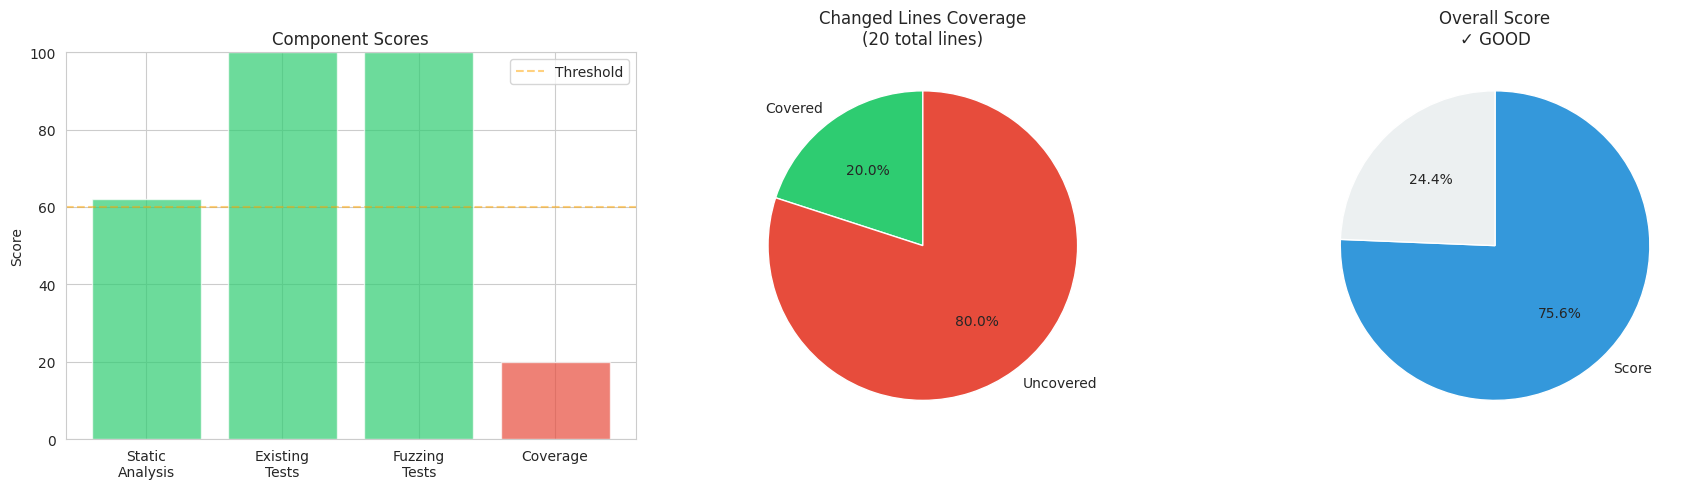

✓ Visualization saved to fuzzing_pipeline_viz_REAL_COVERAGE.png


In [18]:
# Create visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Component scores
ax1 = axes[0]
components = ['Static\nAnalysis', 'Existing\nTests', 'Fuzzing\nTests', 'Coverage']
scores = [
    sqi_score * 100,
    100 if existing_tests_pass else 0,
    100 if fuzzing_success else 0,
    actual_coverage * 100  # 🔥 REAL COVERAGE
]
colors_bar = ['#2ecc71' if s >= 60 else '#e74c3c' for s in scores]
ax1.bar(components, scores, color=colors_bar, alpha=0.7)
ax1.set_ylim(0, 100)
ax1.set_ylabel('Score')
ax1.set_title('Component Scores')
ax1.axhline(y=60, color='orange', linestyle='--', alpha=0.5, label='Threshold')
ax1.legend()

# Coverage breakdown
ax2 = axes[1]
coverage_labels = ['Covered', 'Uncovered']
coverage_values = [total_covered, len(uncovered_lines)]
coverage_colors = ['#2ecc71', '#e74c3c']
ax2.pie(coverage_values, labels=coverage_labels, colors=coverage_colors, 
        autopct='%1.1f%%', startangle=90)
ax2.set_title(f'Changed Lines Coverage\n({total_changed} total lines)')

# Overall score gauge
ax3 = axes[2]
gauge_colors = {'green': '#2ecc71', 'blue': '#3498db', 'orange': '#f39c12', 'red': '#e74c3c'}
ax3.pie([overall_score, 100-overall_score], 
        labels=['Score', ''],
        colors=[gauge_colors.get(color, '#95a5a6'), '#ecf0f1'],
        startangle=90,
        counterclock=False,
        autopct='%1.1f%%' if overall_score > 5 else '')
ax3.set_title(f'Overall Score\n{verdict.split("(")[0].strip()}')

plt.tight_layout()
plt.savefig('fuzzing_pipeline_viz_REAL_COVERAGE.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Visualization saved to fuzzing_pipeline_viz_REAL_COVERAGE.png")